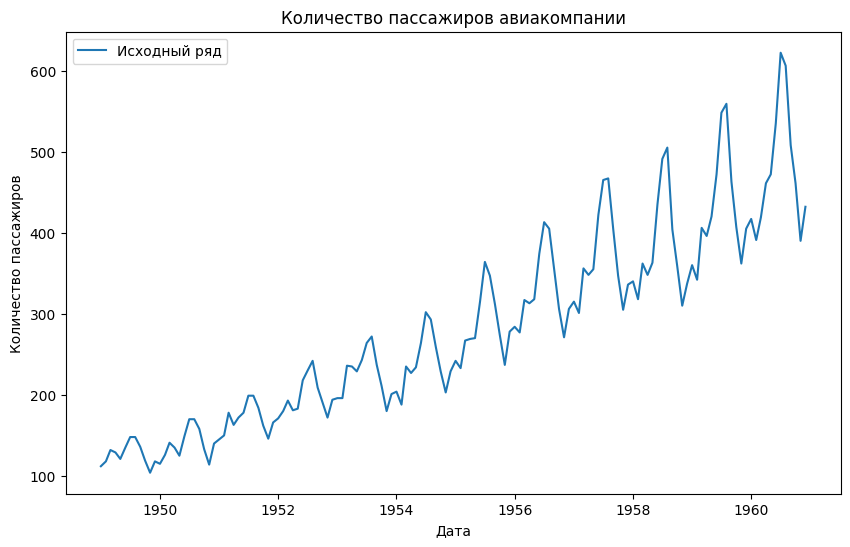

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Загрузка данных
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                   index_col='Month', parse_dates=True)
data.columns = ['Passengers']

# Визуализация исходного ряда
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'], label='Исходный ряд')
plt.title('Количество пассажиров авиакомпании')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

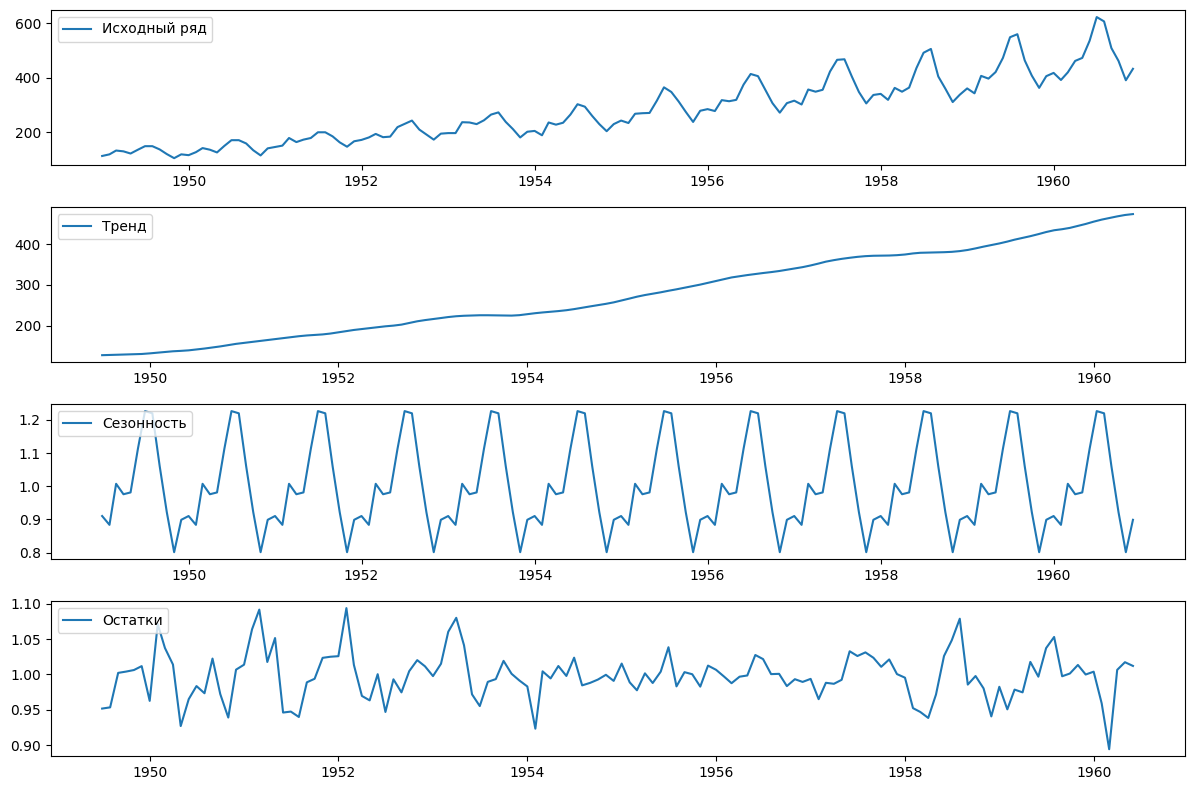

In [2]:
# Сезонная декомпозиция
decomposition = seasonal_decompose(data['Passengers'], model='multiplicative')

# Визуализация компонентов
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Исходный ряд')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остатки')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

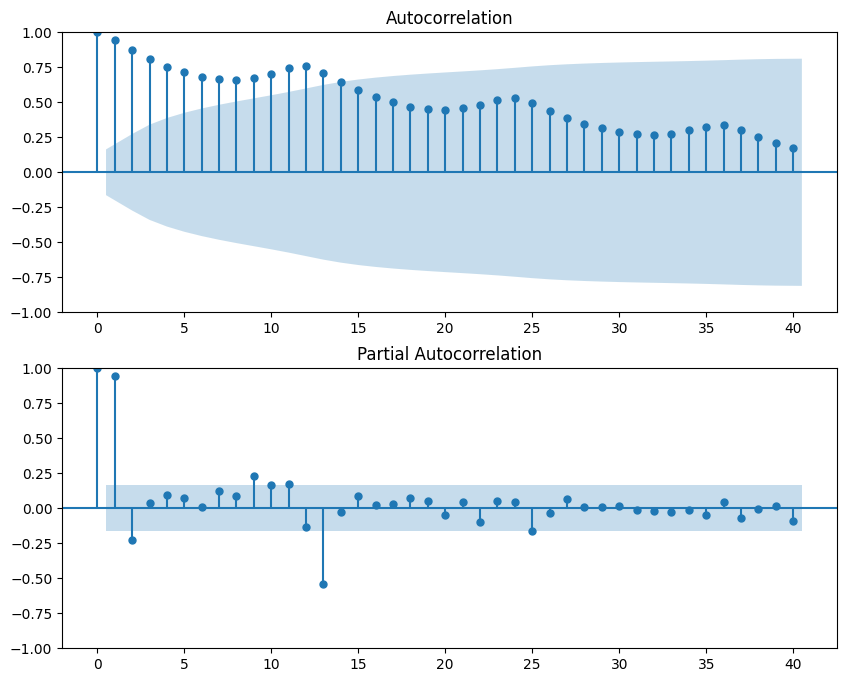

In [3]:
# ACF и PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data['Passengers'], lags=40, ax=ax[0])
plot_pacf(data['Passengers'], lags=40, ax=ax[1])
plt.show()

In [4]:
# Разделение данных
train = data[:'1959']
test = data['1960':]

In [5]:
# Подбор параметров ARIMA
model_arima = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True)

# Обучение модели
model_arima.fit(train)

# Прогноз
forecast_arima = model_arima.predict(n_periods=len(test))

# Добавление прогноза в тестовую выборку
test['Forecast_ARIMA'] = forecast_arima

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=1.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.35 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.71 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.14 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.37 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

E:\Temp\ipykernel_10080\1272429109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast_ARIMA'] = forecast_arima


In [6]:
# Обучение модели Хольта-Уинтерса
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()

# Прогноз
forecast_hw = model_hw.forecast(len(test))

# Добавление прогноза в тестовую выборку
test['Forecast_HW'] = forecast_hw

e:\Github\ITMO_subjects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\Temp\ipykernel_10080\2193304428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast_HW'] = forecast_hw


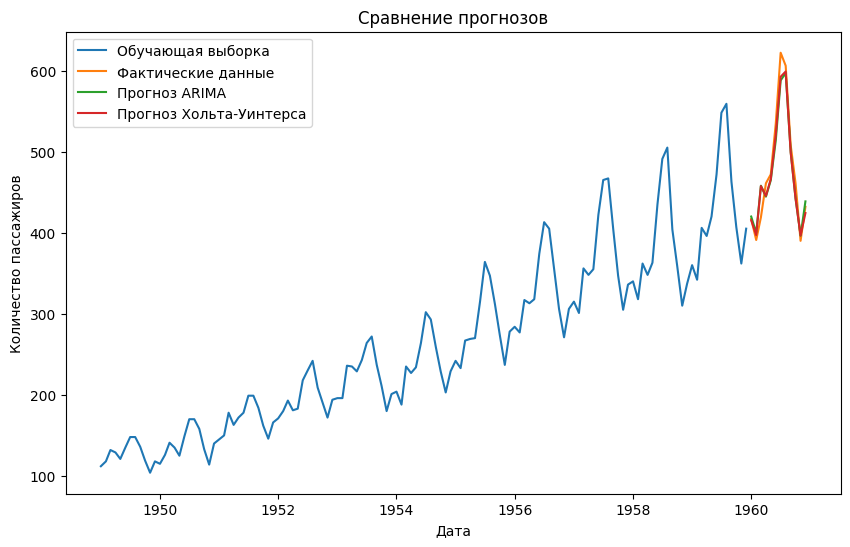

In [7]:
# Визуализация прогнозов
plt.figure(figsize=(10, 6))
plt.plot(train, label='Обучающая выборка')
plt.plot(test['Passengers'], label='Фактические данные')
plt.plot(test['Forecast_ARIMA'], label='Прогноз ARIMA')
plt.plot(test['Forecast_HW'], label='Прогноз Хольта-Уинтерса')
plt.title('Сравнение прогнозов')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

In [8]:
# RMSE для ARIMA
rmse_arima = np.sqrt(mean_squared_error(test['Passengers'], test['Forecast_ARIMA']))

# RMSE для Хольта-Уинтерса
rmse_hw = np.sqrt(mean_squared_error(test['Passengers'], test['Forecast_HW']))

print(f'RMSE ARIMA: {rmse_arima}')
print(f'RMSE Хольта-Уинтерса: {rmse_hw}')

RMSE ARIMA: 18.536469014046745
RMSE Хольта-Уинтерса: 16.979906128442913


In [9]:
from itertools import product

def tune_arima_params(train, test, p_range, d_range, q_range, P_range, D_range, Q_range, m):
    """
    Функция для тюнинга параметров ARIMA.
    
    Параметры:
    - train: обучающая выборка
    - test: тестовая выборка
    - p_range: диапазон для p (AR)
    - d_range: диапазон для d (I)
    - q_range: диапазон для q (MA)
    - P_range: диапазон для сезонного AR (P)
    - D_range: диапазон для сезонного I (D)
    - Q_range: диапазон для сезонного MA (Q)
    - m: сезонный период
    
    Возвращает:
    - best_params: лучшие параметры (p, d, q, P, D, Q)
    - best_rmse: минимальное значение RMSE
    """
    best_rmse = float('inf')
    best_params = None
    
    # Перебор всех комбинаций параметров
    for p, d, q, P, D, Q in product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            # Обучение модели ARIMA с текущими параметрами
            model = auto_arima(train, seasonal=True, m=m,
                               start_p=p, start_d=d, start_q=q,
                               max_p=p, max_d=d, max_q=q,
                               start_P=P, start_D=D, start_Q=Q,
                               max_P=P, max_D=D, max_Q=Q,
                               suppress_warnings=True, trace=True)
            model.fit(train)
            
            # Прогноз на тестовой выборке
            forecast = model.predict(n_periods=len(test))
            
            # Вычисление RMSE
            rmse = np.sqrt(mean_squared_error(test, forecast))
            
            # Обновление лучших параметров, если RMSE уменьшилось
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (p, d, q, P, D, Q)
        except:
            # Пропуск ошибок, связанных с нестабильностью модели
            continue
    
    return best_params, best_rmse

In [11]:
# Определение диапазонов для параметров
p_range = range(0, 3)  # AR
d_range = range(0, 2)  # I
q_range = range(0, 3)  # MA
P_range = range(0, 3)  # Сезонный AR
D_range = range(0, 2)  # Сезонный I
Q_range = range(0, 3)  # Сезонный MA
m = 12  # Сезонный период (для месячных данных)

# Тюнинг параметров
best_params, best_rmse = tune_arima_params(train['Passengers'], test['Passengers'],
                                          p_range, d_range, q_range,
                                          P_range, D_range, Q_range, m)

print(f"Лучшие параметры p, d, q, P, D, Q: {best_params}")
print(f"Минимальное RMSE: {best_rmse}")

Лучшие параметры p, d, q, P, D, Q: (1, 1, 1, 1, 1, 2)
Минимальное RMSE: 15.648745419893837
